# imports

In [1]:
%load_ext autoreload
%autoreload 2
packages = !conda list
len(packages),packages

(455,
 ['# packages in environment at /Users/brucecottman/anaconda3:',
  '#',
  '# Name                    Version                   Build  Channel',
  '_anaconda_depends         2019.10                  py37_0  ',
  '_ipyw_jlab_nb_ext_conf    0.1.0                    py37_0  ',
  'absl-py                   0.7.0                    pypi_0    pypi',
  'alabaster                 0.7.12                   py37_0  ',
  'altair                    4.0.0                    pypi_0    pypi',
  'anaconda                  custom                   py37_1  ',
  'anaconda-client           1.7.2                    py37_0  ',
  'anaconda-navigator        1.9.6                    py37_0  ',
  'anaconda-project          0.8.2                    py37_0  ',
  'appdirs                   1.4.3                    pypi_0    pypi',
  'appnope                   0.1.0                    py37_0  ',
  'appscript                 1.0.1            py37h1de35cc_1  ',
  'argh                      0.26.2                 

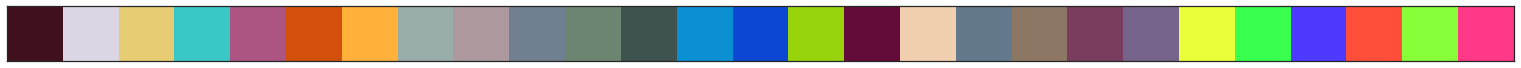

In [2]:
from __future__ import print_function
import matplotlib
import matplotlib.dates as mdates
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sys, os
import io
from typing import Dict, Pattern

import seaborn as sns; sns.set()  # for plot styling
#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

#define a custom palette
PALLET = ['#40111D', '#DCD5E4', '#E7CC74'
                 ,'#39C8C6', '#AC5583', '#D3500C'
                 ,'#FFB139', '#98ADA7', '#AD989E'
                 ,'#708090','#6C8570','#3E534D'

                 ,'#0B8FD3','#0B47D3','#96D30B'                 
                 ,'#630C3A','#F1D0AF','#64788B'                 
                 ,'#8B7764','#7A3C5D','#77648B'
                 ,'#eaff39','#39ff4e','#4e39ff'
                 ,'#ff4e39','#87ff39','#ff3987', ]
N_PALLET = len(PALLET)
sns.set_palette(PALLET)
sns.palplot(PALLET)

In [3]:
# add if you want to add google driveAssertionError
old__file__ = !pwd
__file__ =  old__file__  #!cd ../../NLP ;pwd
#__file__ = !pwd
#__file__ = '/gdrive/My Drive'

sys.path.append(__file__)
print(sys.path)
os.chdir(old__file__[0])
!pwd
__file__

['/Users/brucecottman/Documents/PROJECTS/FinMrkt/src', '/usr/local/Cellar/apache-spark/2.0.1/libexec/python', '/Users/brucecottman/Documents/PROJECTS/FinMrkt/src/$', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python37.zip', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/lib-dynload', '', '/Users/brucecottman/Library/Python/3.7/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/extensions', '/Users/brucecottman/.ipython', ['/Users/brucecottman/Documents/PROJECTS/FinMrkt/src']]
/Users/brucecottman/Documents/PROJECTS/FinMrkt/src


['/Users/brucecottman/Documents/PROJECTS/FinMrkt/src']

## define future value function

In [4]:
from base import FutureValue_, nppy_
from base import return_fit, price_std,  price_std_f
from base import p_or_r_std, p_or_r_std_f, ticket_read
from base import register_DataFrame_method
from pandas import to_datetime, DataFrame
from statistics import stdev
from pandas_datareader.data import DataReader

## fit plot

In [5]:
from scipy.optimize import curve_fit

def peb(df, ticker, column_name, nppy, low_bounds, high_bounds,nstd):
    # nppy: number of periods per year
    # low_bounds: [low_priniple, low_yield ]
    # high_bounds: [high_priniple, high_yield ]
    #nstd: number of standard deviation = 2*width of error banner

    xddata = df.index  #dates array for axis
    nper = df.index.size # number of periods
    xdata = np.linspace(1,nper,num=nper).astype(int)
    df['ID'] = xdata
    y_data = df[column_name].to_numpy()

             
    # Compute upper and lower bounds using chosen uncertainty measure: here
    # it is a fraction of the standard deviation of measurements at each
    # time point based on the unbiased sample variance
    popt, pcov = curve_fit(return_fit, xdata, y_data, method='trf', 
                           bounds=(low_bounds, high_bounds))

    yfit_data= return_fit(xdata, *popt)
    # trend line, high error, low error
    df['y_fit'] = yfit_data
    yfit_data_low =  return_fit(xdata, (*popt- std_error))
    df['y_fit_low'] = yfit_data_low
    yfit_data_high =  return_fit(xdata, (*popt + std_error))
    df['y_fit_high'] = yfit_data_high


    sns.set(rc={'figure.figsize':(12, 6)})
    fig, ax = plt.subplots(figsize=(12,6))
    fig.autofmt_xdate(rotation=45)
    #
    ntm = 19
    interv = nper//ntm  # interval between 25 tick marks
    nppy = nppy_(df)
    
    if interv < 1: interv = 1
        # weekly instead of yearly x axis labels
    if (nppy == 52): 
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=interv))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
#    monthly instead of yearly x axis labels
    elif (nppy == 12): 
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interv))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    # We change the fontsize of minor ticks label 
    
    
    ax.tick_params(axis='both', which='major', labelsize=14)
    # plot raw data
    ax.plot(xddata, y_data, color='black', label='yield')
    # plot fitted yield trend line
    ax.plot(xddata, yfit_data, color='tab:blue', label='yield fit')
    # plot fitted yield lowabs error trend line
    ax.plot(xddata, yfit_data_low, color='tab:blue', alpha=0.1)
    # plot fitted yield high error trend line
    ax.plot(xddata, yfit_data_high, color='tab:blue', alpha=0.1)
    # plot error band
    ax.fill_between(xddata, yfit_data_low, yfit_data_high, alpha=0.2)
    ax.set_ylabel('price($)',size=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ###  Annotate
    astr = "TICKER= {:}\n PRINCIPAL= ${:.2f} \nRETURN= {:.2%}/year".format(ticker, popt[0], popt[1]*nppy) 
    ax.annotate(
        astr,
        xy=(0.5, 0.7), xycoords=ax.transAxes,
        xytext=(-60, 18), textcoords='offset points',
        size=20,
        bbox=dict(boxstyle="round4,pad=.5", fc="0.8"),)

    plt.show()


a## read

In [6]:
#!pip install pandas_datareader #if not already installed 

In [7]:
from pandas_datareader.data import DataReader

import copy

import plotly.express as px

In [8]:
## read CPI

In [9]:
from pandas_datareader.data import DataReader

ticker = 'VGT'
rd_type = 'yahoo'
start_date = '2000/01/01' 
end_date = '2022/05/11'
EFT_df = DataReader(ticker, rd_type, start = start_date, end = end_date)
EFT_df.index = pd.to_datetime(EFT_df.index, format ='%Y-%m-%d')
# RETURNS
column_name =  'Adj Close'
((sum(EFT_df[column_name]- EFT_df[column_name].shift(1))**2)/EFT_df[column_name].size)**0.5

nan

In [10]:
ticker = '^IXIC'
rd_type = 'yahoo'
start_date = '1970/01/01' 
end_date = '2022/05/11'
column_name =  'Adj Close'
EFT_df = DataReader(ticker, rd_type, start = start_date, end = end_date)
EFT_df.size

77580

##  standard deviation of price and return

The equation for a standard deviation of a series of prices:
  
\begin{equation}
s = \sqrt{\frac{1}{N-1} \sum_{i=1}^N (p_i - \overline{p})^2}
\end{equation}

  
\begin{equation}
s = \sqrt{\frac{1}{N-1} \sum_{i=2}^N (p_{i+1} - p_{i} - \overline{r})^2}
\end{equation}

\begin{equation}
s = \sqrt{\frac{1}{N-1} \sum_{i=1}^{N-1} (r_i - \overline{r})^2}
\end{equation}

## POPULATION   $$ N$$

In [11]:
import statistics
statistics.pstdev(EFT_df[column_name])

2993.071426598538

## DEGRESS OF FREEDOM $$N-1$$

In [12]:
statistics.stdev(EFT_df[column_name]),

(2993.1871746669763,)

## function for price std 

In [13]:
ticker = '^IXIC'
rd_type = 'yahoo'
start_date = '1970/01/01' 
end_date = '2022/05/11'
column_name =  'Adj Close'

price_std(EFT_df,column_name,ticker, 
          rd_type, start_date, end_date)



2993.1871746669763

In [14]:
price_std_f(EFT_df,column_name,ticker, 
          rd_type, start_date, end_date)

2993.1871746669763

# Read CPI

\begin{equation}
 r_i = p_i - p_{i-1}
\end{equation}

\begin{equation}
r_i = (p_i - p_{i-1})/(p_{i-1})
\end{equation}  

## us exchange

In [56]:
ticker = 'IBM'
rd_type = 'yahoo'
start_date = '1960/05/10'
end_date = '2022/07/30'
column_name =  'Adj Close'
EFT_df = DataReader(ticker, rd_type, 
                        start = start_date, end = end_date)
EFT_df.head(n=2), EFT_df.tail(n=2)

(                High       Low      Open     Close    Volume  Adj Close
 Date                                                                   
 1962-01-02  7.374124  7.291268  7.374124  7.291268  407940.0   1.673324
 1962-01-03  7.355003  7.291268  7.291268  7.355003  305955.0   1.687953,
                   High         Low        Open       Close      Volume  \
 Date                                                                     
 2022-06-16  136.240005  134.389999  135.300003  135.669998   5386400.0   
 2022-06-17  136.979996  132.850006  135.990005  135.020004  12967300.0   
 
              Adj Close  
 Date                    
 2022-06-16  135.669998  
 2022-06-17  135.020004  )

## london exchange

In [ ]:
ticker = 'IBM.L'
rd_type = 'yahoo'
start_date = '1960/05/10'
end_date = '2022/07/30'
column_name =  'Adj Close'
EFT_df = DataReader(ticker`, rd_type, 
                        start = start_date, end = end_date)
EFT_df.head(n=2), EFT_df.tail(n=2)

## dow jones index exchange

In [59]:
ticker = '^DJI'
rd_type = 'yahoo'
start_date = '1900/01/01' 
end_date = '2022/05/11'
column_name =  'Adj Close'
EFT_df = DataReader(ticker, rd_type, 
                        start = start_date, end = end_date)
EFT_df.head(n=2), EFT_df.tail(n=2)

(                   High          Low         Open        Close    Volume  \
 Date                                                                       
 1992-01-02  3172.629883  3139.310059  3152.100098  3172.399902  23550000   
 1992-01-03  3210.639893  3165.919922  3172.399902  3201.500000  23620000   
 
               Adj Close  
 Date                     
 1992-01-02  3172.399902  
 1992-01-03  3201.500000  ,
                     High           Low          Open         Close     Volume  \
 Date                                                                            
 2022-05-10  32752.169922  31887.890625  32504.089844  32160.740234  439290000   
 2022-05-11  32584.019531  31798.859375  32123.240234  31834.109375  458460000   
 
                Adj Close  
 Date                      
 2022-05-10  32160.740234  
 2022-05-11  31834.109375  )

# FRED

## CPI exchange from fred

In [60]:
ticker = 'MEDCPIM158SFRBCLE'
rd_type = 'fred'
start_date = '1960/05/10'
end_date = '2022/07/30'
column_name =  'Adj Close'
EFT_df = DataReader(ticker, rd_type, 
                        start = start_date, end = end_date)
EFT_df.head(n=2), EFT_df.tail(n=2)

(            MEDCPIM158SFRBCLE
 DATE                         
 1983-01-01           5.014653
 1983-02-01           4.952545,
             MEDCPIM158SFRBCLE
 DATE                         
 2022-04-01           6.527993
 2022-05-01           7.211770)

In [39]:
m=EFT_df.columns
m[0]


'MEDCPIM158SFRBCLE'

In [16]:
ticker = '^DJI'
rd_type = 'yahoo'
start_date = '1900/01/01' 
end_date = '2022/05/11'
column_name =  'Adj Close'
asset_value_type = 'RETURN'


In [17]:
p_or_r_std(EFT_df,asset_value_type, rd_type, column_name,ticker, 
            start_date, end_date)

(0.0916788714433425, 0.011143620061387976)

In [18]:
dir(EFT_df)

['FPCPITOTLZGUSA',
 'T',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_SLICEMAP',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__bytes__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv

In [19]:
p_or_r_std_f(EFT_df, asset_value_type, rd_type, column_name,ticker, 
          start_date, end_date)

(0.0916788714433425, 0.011143620061387976)

In [21]:
tickers = ['VTI', 'VGT' ,'VO' , 'VOO', 'VVIAX', 'METV', 'TMFC']
for ticker in tickers:
    rd_type = 'yahoo'
    start_date = '2000/01/01' 
    end_date = '2022/05/11'
    column_name =  'Adj Close'
    asset_value_type = 'RETURN'

    print(ticker, ' ')
    print(p_or_r_std(EFT_df, asset_value_type, rd_type, column_name,ticker, 
          start_date, end_date))


VTI  
(0.09737427879139299, 0.012247150469665288)
VGT  
(0.13881577760908237, 0.013905802986450489)
VO  
(0.11419034614075356, 0.013271429366502425)
VOO  
(0.14289622967992902, 0.010807528044353825)
VVIAX  
(0.08437330184359891, 0.012694740883674014)
METV  
(-0.6387902840266639, 0.022172335936613115)
TMFC  
(0.15116242054099402, 0.014988064435317744)


In [ ]:
tickers = ['BNDX', 'BND', '^IXIC', '^DJI', 'VOO', 'VXUS', 'VTI', 'VTSAX' , 'VVIAX', 'VGT' ,'TMFC', 'METV', 'AAPL' ]
for ticker in tickers:
    rd_type = 'yahoo'
    start_date = '2000/01/01' 
    end_date = '2022/05/11'
    column_name =  'Adj Close'
    asset_value_type = 'RETURN'
    return_, r_std = p_or_r_std(EFT_df, asset_value_type, rd_type, column_name,ticker, 
          start_date, end_date)

    print('{:5}  ave_return= {:4.4%}/year   std_return= {:2.2%}    return/std= {:1.6}/year'.format(ticker, return_, r_std, return_/r_std))

## Systematic Risk

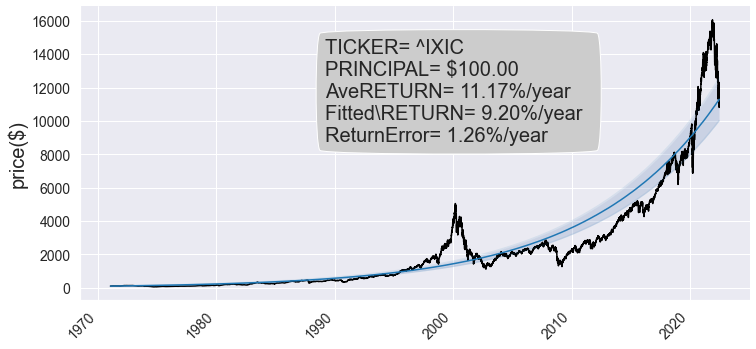

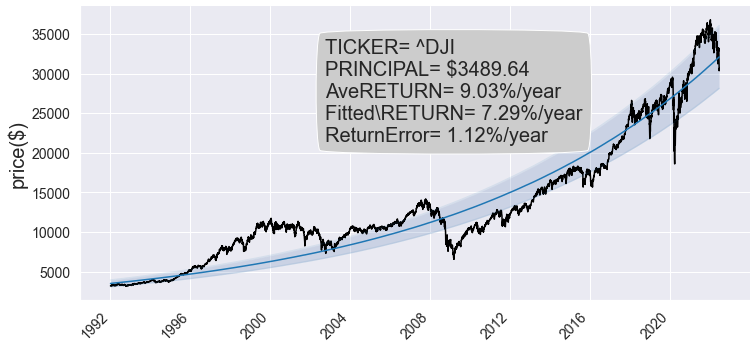

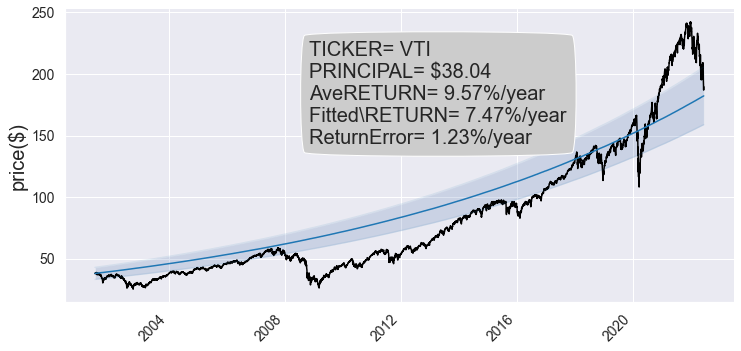

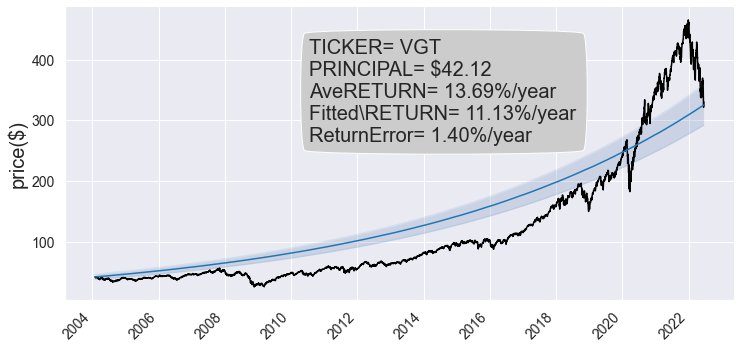

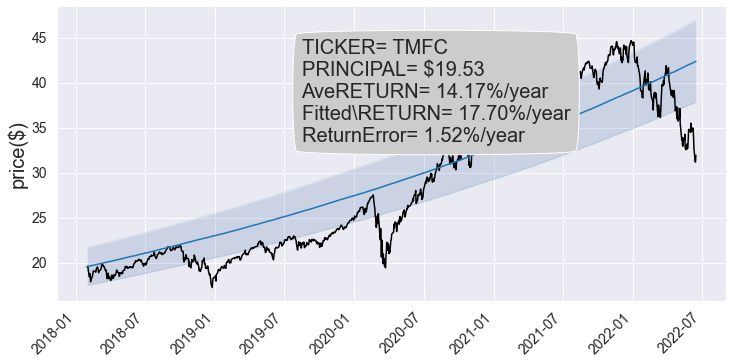

In [22]:
tickers = ['^IXIC', '^DJI','VTI','VGT' ,'TMFC']
#tickers = ['^DJI']
for ticker in tickers:
    start_date = '1900/01/01' 
    end_date = '2022/06/15'
    ticket_read(start_date, end_date, ticker)

In [24]:
tickers = ['FPCPITOTLZGUSA']
rd_type = 'fred'
#tickers = ['^IXIC', '^DJI','VTI','VGT' ,'TMFC']
#tickers = ['^DJI']
for ticker in tickers:
    start_date = '1960/01/01' 
    end_date = '2022/06/30'
    ticket_read(start_date, end_date, ticker, rd_type = 'fred')


KeyError: 'Adj Close'